In [1]:
import os
import tarfile
import urllib.request
import warnings
warnings.filterwarnings("ignore")

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [2]:
fetch_housing_data()

In [3]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path=os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)
    

In [4]:
housing=load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
housing.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


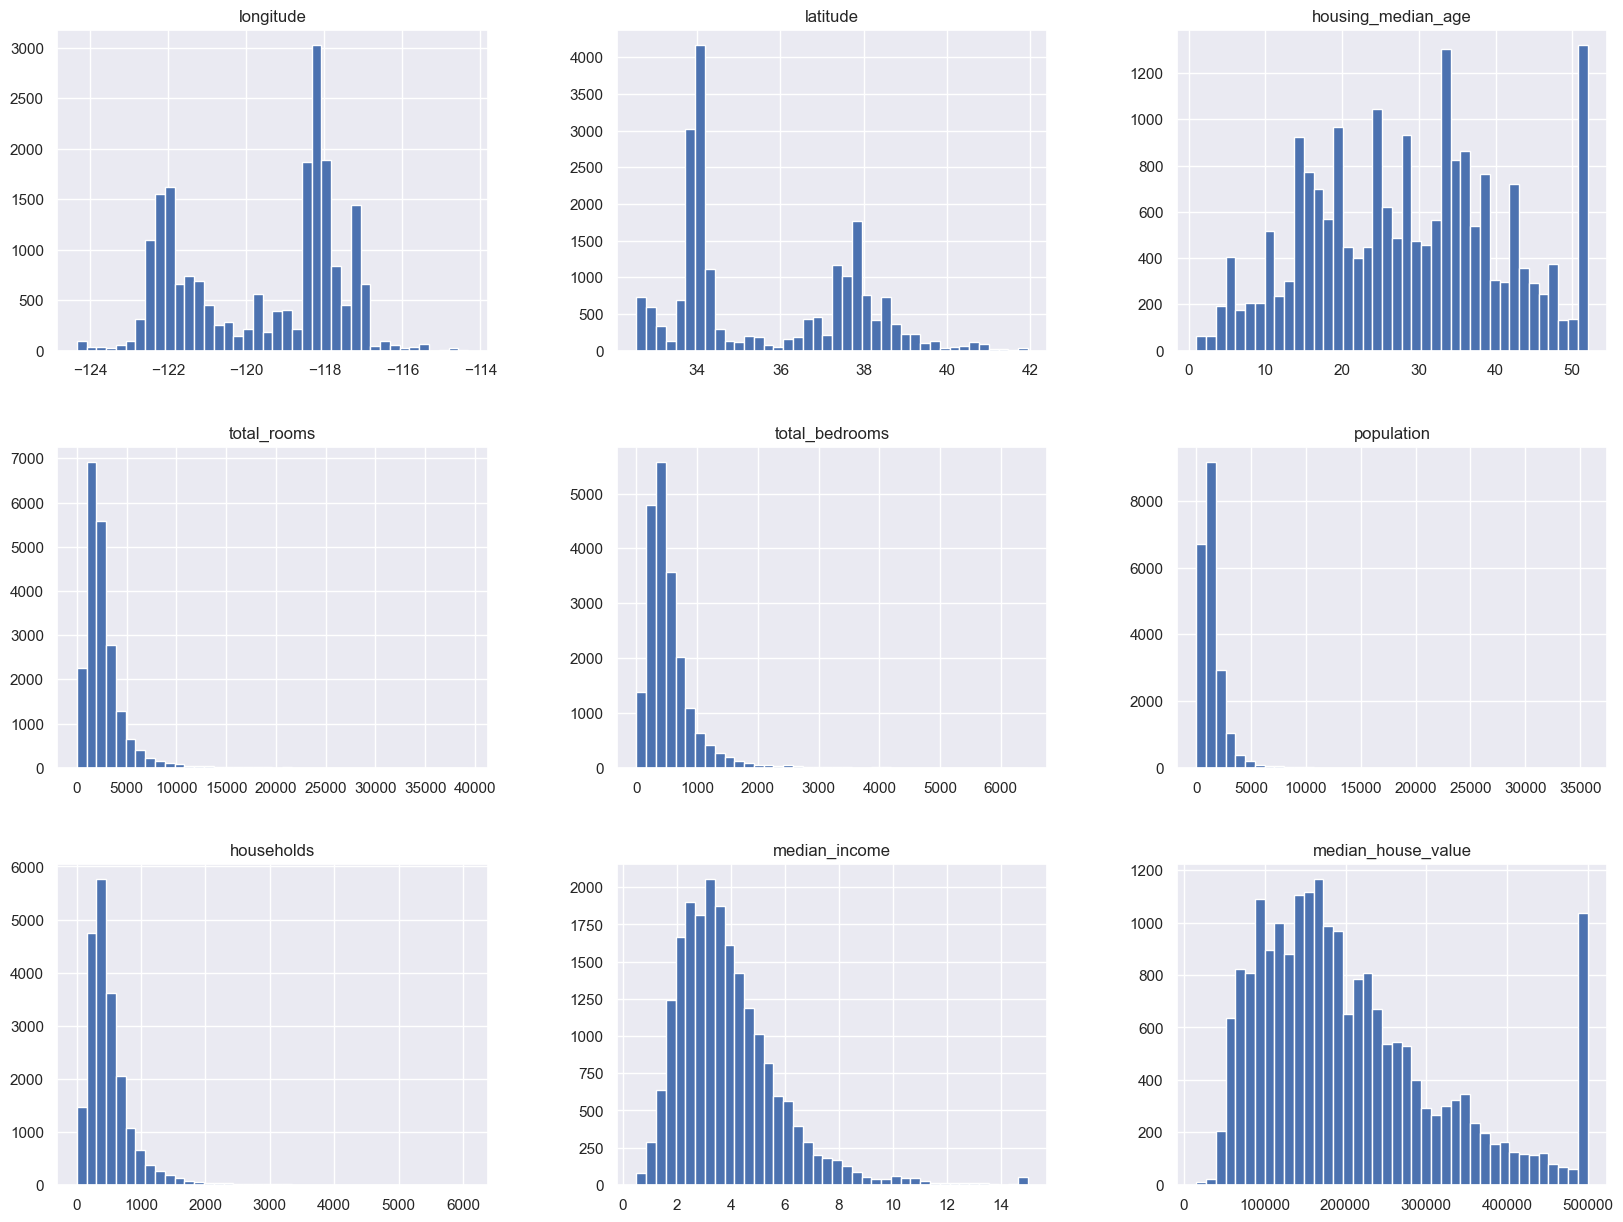

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

housing.hist(bins=40, figsize=(20,15))
plt.show()

### Setting aside a test set

In [9]:
import numpy as np
np.random.seed(42)

In [10]:
def split_train_test(data, test_ratio):
    shuffled_indices=np.random.permutation(len(data))
    test_set_size=int(len(data)*test_ratio)
    test_indices=shuffled_indices[:test_set_size]
    train_indices=shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [11]:
train_set, test_set=split_train_test(housing, 0.2)
len(train_set)

16512

In [12]:
len(test_set)

4128

In [13]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]


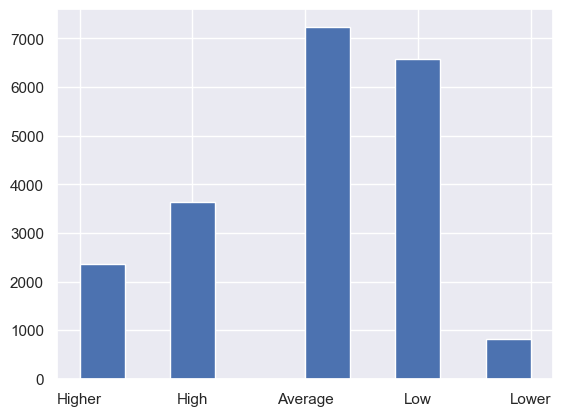

In [14]:
#just for fun: create categories in the income column
housing['income_cat']=pd.cut(housing['median_income'],
                         bins=[0.,1.5,3.0,4.5,6.,np.inf],
                         labels=['Lower','Low','Average','High','Higher'])
housing['income_cat'].hist();

In [15]:
#do some stratified sampling

from sklearn.model_selection import StratifiedShuffleSplit

st=StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in st.split(housing, housing['income_cat']):
    strat_train_set=housing.loc[train_index]
    strat_test_set=housing.loc[test_index]

In [16]:
strat_test_set['income_cat'].value_counts()/len(strat_test_set)

Average    0.350533
Low        0.318798
High       0.176357
Higher     0.114341
Lower      0.039971
Name: income_cat, dtype: float64

In [17]:
housing['income_cat'].value_counts()/len(housing)

Average    0.350581
Low        0.318847
High       0.176308
Higher     0.114438
Lower      0.039826
Name: income_cat, dtype: float64

In [18]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100


<IPython.core.display.Javascript object>

In [19]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
Lower,0.039826,0.039971,0.040213,0.973236,0.364964
Low,0.318847,0.318798,0.324370,1.732260,-0.015195
Average,0.350581,0.350533,0.358527,2.266446,-0.013820
High,0.176308,0.176357,0.167393,-5.056334,0.027480
Higher,0.114438,0.114341,0.109496,-4.318374,-0.084674


In [20]:
strat_train_set.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'income_cat'],
      dtype='object')

In [21]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

In [22]:
strat_train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
15940,-122.41,37.72,35.0,2104.0,434.0,1225.0,410.0,4.8214,242900.0,NEAR BAY
10335,-117.78,33.82,12.0,6208.0,750.0,2443.0,739.0,9.1808,413700.0,<1H OCEAN
20026,-119.05,36.06,23.0,2344.0,407.0,1184.0,406.0,3.1625,70600.0,INLAND
19059,-122.49,38.22,33.0,1486.0,290.0,781.0,274.0,3.5647,251800.0,NEAR BAY
804,-122.06,37.65,33.0,1227.0,286.0,848.0,291.0,3.8036,158200.0,NEAR BAY


### EDA

In [23]:
#create a copy
housing=strat_train_set.copy()

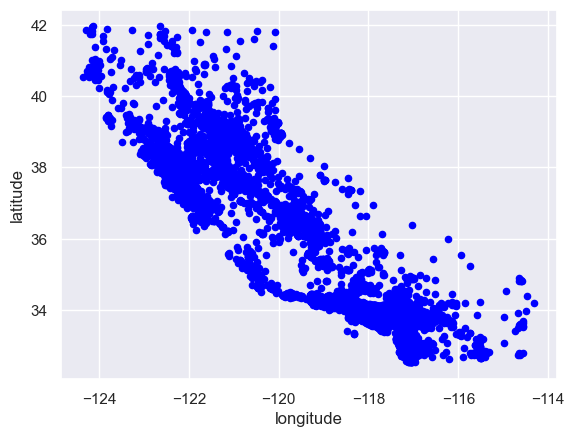

In [24]:
#Visualizing Geographical data
housing.plot(kind='scatter', x='longitude', y='latitude', c='blue');

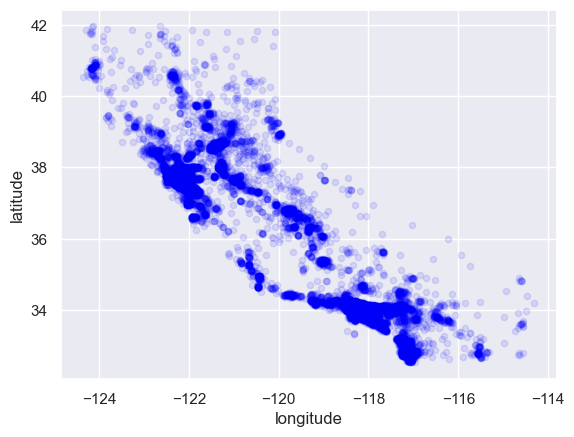

In [25]:
#high density areas
housing.plot(kind="scatter", x="longitude", y="latitude", c='blue', alpha=0.1);

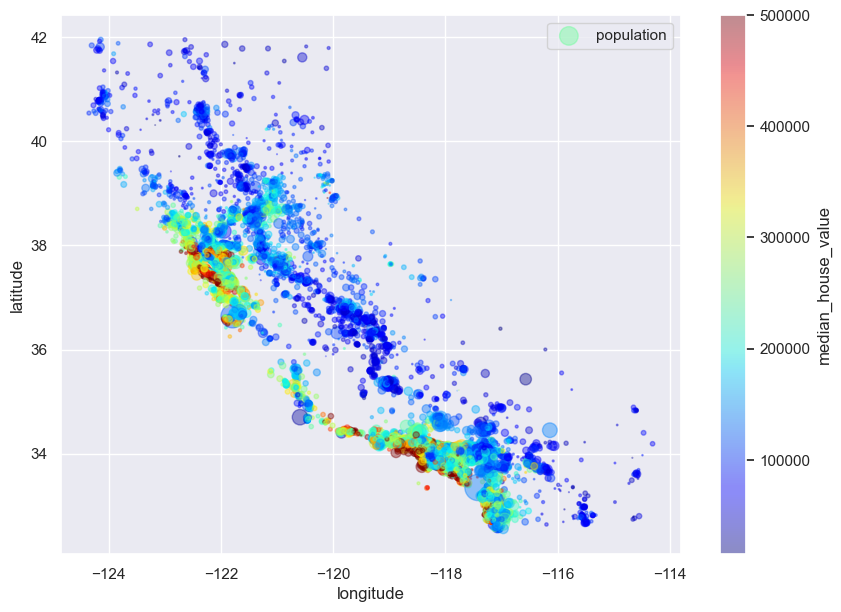

In [26]:
#for even better visualizations
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
            s=housing['population']/100, label='population', figsize=(10,7),
            c='median_house_value', cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend();

In [27]:
# Download the California image
PROJECT_ROOT_DIR="."
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('.\\images\\end_to_end_project\\california.png',
 <http.client.HTTPMessage at 0x20ef9e32550>)

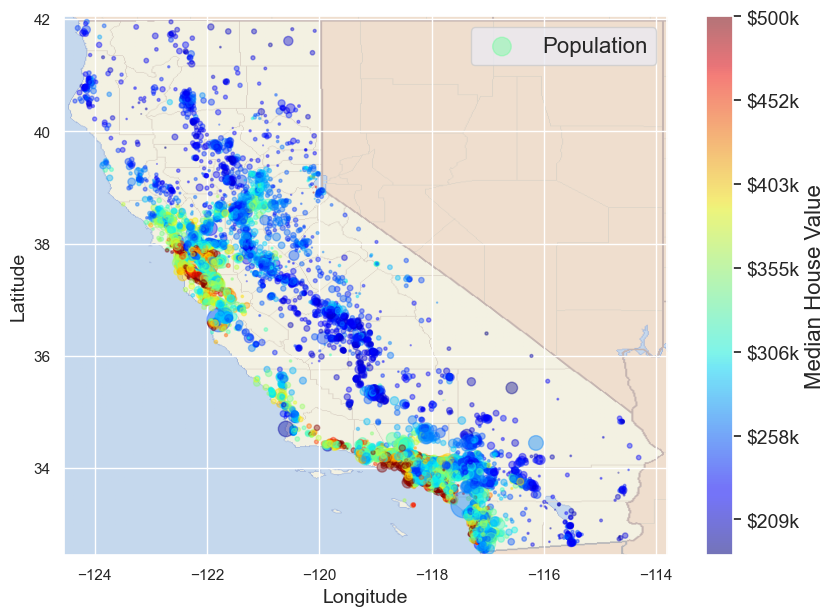

In [28]:
import matplotlib.image as mpimg
california_img=mpimg.imread(os.path.join(images_path, filename))
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                  s=housing['population']/100, label="Population",
                  c="median_house_value", cmap=plt.get_cmap("jet"),
                  colorbar=False, alpha=0.4)
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
plt.show();

### Correlations

In [29]:
corr_matrix=housing.corr()

In [30]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688680
total_rooms           0.136809
housing_median_age    0.099939
households            0.067921
total_bedrooms        0.051541
population           -0.023099
longitude            -0.047758
latitude             -0.144249
Name: median_house_value, dtype: float64

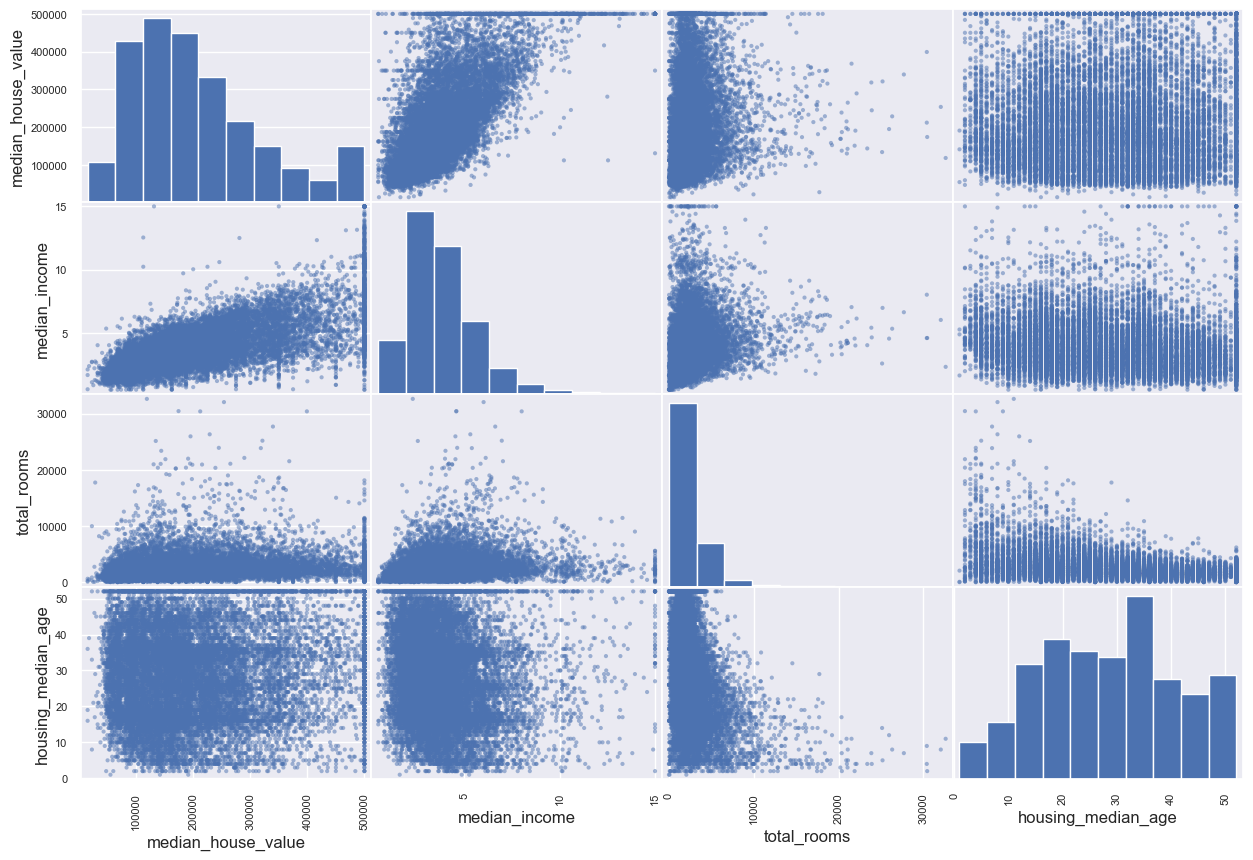

In [31]:
from pandas.plotting import scatter_matrix

attributes=["median_house_value", "median_income","total_rooms",
           "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(15,10));

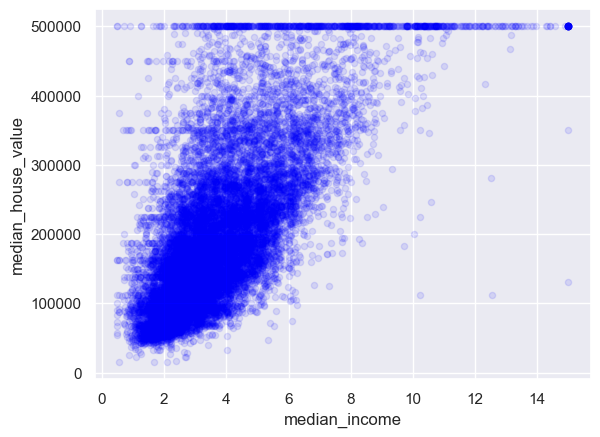

In [32]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
            alpha=0.1, c='blue');

### Experimenting with Attribute combinations

In [33]:
housing['rooms_per_household']=housing['total_rooms']/housing['households']
housing['bedrooms_per_room']=housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household']=housing['population']/housing['households']

In [34]:
corr_matrix=housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688680
rooms_per_household         0.152939
total_rooms                 0.136809
housing_median_age          0.099939
households                  0.067921
total_bedrooms              0.051541
population                 -0.023099
population_per_household   -0.032859
longitude                  -0.047758
latitude                   -0.144249
bedrooms_per_room          -0.255216
Name: median_house_value, dtype: float64

### Preprocessing

In [35]:
housing=strat_train_set.drop("median_house_value", axis=1)
housing_labels=strat_train_set['median_house_value'].copy()

- Cleaning

In [36]:
housing.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        173
population              0
households              0
median_income           0
ocean_proximity         0
dtype: int64

In [37]:
from sklearn.impute import SimpleImputer

imputer=SimpleImputer(strategy="median")

In [38]:
housing.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
ocean_proximity        object
dtype: object

In [39]:
numerical=housing.drop("ocean_proximity", axis=1)

In [40]:
imputer.fit(numerical)

SimpleImputer(strategy='median')

In [41]:
imputer.statistics_

array([-118.49  ,   34.26  ,   29.    , 2122.    ,  434.    , 1161.    ,
        409.    ,    3.5313])

In [42]:
numerical.median().values

array([-118.49  ,   34.26  ,   29.    , 2122.    ,  434.    , 1161.    ,
        409.    ,    3.5313])

In [43]:
X=imputer.transform(numerical)

In [44]:
#putting it back to a pandas dataframe
training=pd.DataFrame(X, columns=numerical.columns)
training.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
dtype: int64

- Handling categorical columns

In [45]:
categorical=housing[['ocean_proximity']]
categorical.tail()

,ocean_proximity
17370,<1H OCEAN
6756,<1H OCEAN
7382,<1H OCEAN
14562,NEAR OCEAN
5287,<1H OCEAN


In [46]:
categorical.value_counts()

ocean_proximity
<1H OCEAN          7336
INLAND             5221
NEAR OCEAN         2116
NEAR BAY           1835
ISLAND                4
dtype: int64

In [47]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
OE=OrdinalEncoder()

In [48]:
encoded=OE.fit_transform(categorical)
encoded[5:]

array([[4.],
       [1.],
       [0.],
       ...,
       [0.],
       [4.],
       [0.]])

In [49]:
OE.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [50]:
hot=OneHotEncoder()
hot_encoded=hot.fit_transform(categorical)
hot_encoded

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [51]:
hot_encoded.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.]])

In [52]:
hot.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

#### Custom transformers

In [53]:
from  sklearn.base import BaseEstimator, TransformerMixin

rooms, bedrooms, population, households= 3,4,5,6

class AddAttributes(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room=add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X,y=None):
        rooms_per_household=X[:, rooms]/X[:, households]
        population_per_household=X[:, population]/X[:,households]
        if self.add_bedrooms_per_room:
            bedrooms_per_room=X[:,bedrooms]/X[:,rooms]
            return np.c_[X,rooms_per_household, population_per_household,
                        bedrooms_per_room]
        else:
            return np.c_[X,rooms_per_household, population_per_household]
        
adder=AddAttributes(add_bedrooms_per_room=False)
housing_extra_attributes=adder.transform(housing.values)

#### Feature Scaling
- min-max scaling(normalization) ```MinMaxScaler``` and standardization: ```StandardScaler```

#### Transformation Pipelines

In [54]:
#a pipeline for the numerical features

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

numerical_pipeline=Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('adder', AddAttributes()),
    ('std_scaler', StandardScaler()),
])

housing_num_tr=numerical_pipeline.fit_transform(numerical)

- Transforming both categorical and numerical columns concurrently.

In [55]:
from sklearn.compose import ColumnTransformer

num_attribs=list(numerical)
cat_attribs=['ocean_proximity']

full_pipeline=ColumnTransformer([
    ('num', numerical_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs),
])

processed=full_pipeline.fit_transform(housing)

In [56]:
processed

array([[-1.42240736,  0.98074477,  0.49834111, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.89348602, -0.84812258, -1.32560379, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.25824097,  0.2023038 , -0.45328231, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.65839533, -0.77778152,  0.57764307, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17359408, -1.31237352,  0.1811333 , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.54835288, -0.7402663 , -0.53258427, ...,  0.        ,
         0.        ,  0.        ]])

In [57]:
processed.shape

(16512, 16)

### Selecting and Training the model

- Training and Evaluating on the train set.


In [58]:
from sklearn.linear_model import LinearRegression

reg=LinearRegression()
reg.fit(processed, housing_labels)

LinearRegression()

In [59]:
#try it on some few instances
some_data=housing.iloc[:5]
some_labels=housing_labels.iloc[:5]
some_processed=full_pipeline.transform(some_data)
print(f"\npredictions: {reg.predict(some_processed)}\n\nlabels: {list(some_labels)}")


predictions: [277482.54402128 389798.12858152 113465.55661388 213954.21811428
 228047.25065302]

labels: [242900.0, 413700.0, 70600.0, 251800.0, 158200.0]


In [60]:
some_processed

array([[-1.42240736e+00,  9.80744767e-01,  4.98341114e-01,
        -2.41662451e-01, -2.42248571e-01, -1.71716225e-01,
        -2.31140443e-01,  5.00414488e-01, -1.16416992e-01,
        -5.18215414e-03, -1.14873401e-01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [ 8.93486023e-01, -8.48122576e-01, -1.32560379e+00,
         1.65010458e+00,  5.13678722e-01,  9.06910108e-01,
         6.31742367e-01,  2.79460821e+00,  1.17987556e+00,
         4.45592108e-02, -1.40044356e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 2.58240971e-01,  2.02303795e-01, -4.53282313e-01,
        -1.31032800e-01, -3.06837295e-01, -2.08024665e-01,
        -2.41631419e-01, -3.72604268e-01,  1.38053004e-01,
        -1.63732756e-02, -6.05848427e-01,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-1.46242279e+00,  1.21521494e

In [61]:
from sklearn.metrics import mean_squared_error
predictions=reg.predict(processed)
mse=mean_squared_error(housing_labels, predictions)
rmse=np.sqrt(mse)
rmse

68250.27696679202

In [62]:
from sklearn.metrics import mean_absolute_error
mae=mean_absolute_error(housing_labels, predictions)
mae

49301.39144670877

- DecisionTree Regressor

In [63]:
from sklearn.tree import DecisionTreeRegressor

tree=DecisionTreeRegressor()
tree.fit(processed, housing_labels)

DecisionTreeRegressor()

In [64]:
predictions=tree.predict(processed)
tree_mse=mean_squared_error(housing_labels, predictions, squared=False)
tree_mse

0.0

#### Evaluate the model using Cross-Validation

In [65]:
from sklearn.model_selection import cross_val_score
scores=cross_val_score(tree, processed, housing_labels, 
                      scoring="neg_mean_squared_error", cv=10)
rmse_scores=np.sqrt(-scores)

In [66]:
def display_scores(scores):
    print(f"Scores: {scores}\n\nMean: {scores.mean()}\n\nStd: {scores.std()}")
    
results=display_scores(rmse_scores)

Scores: [66551.96185712 70332.57739583 68059.26214391 67914.46092297
 68302.17985294 66184.79682483 71356.01015347 69557.48520612
 70674.89712671 70881.27025845]

Mean: 68981.49017423569

Std: 1744.9058305194512


In [67]:
reg_scores=cross_val_score(reg, processed, housing_labels,
                          scoring="neg_mean_squared_error", cv=10)

reg_rmse=np.sqrt(-reg_scores)
display_scores(reg_rmse)

Scores: [67121.63315566 66720.69407375 69297.18790888 67421.12804701
 67608.96652496 68893.15766731 67368.61711466 69908.60755317
 71523.32045094 70635.5611944 ]

Mean: 68649.88736907335

Std: 1566.9856411864532


- RandomForest Regressor.

In [68]:
from sklearn.ensemble import RandomForestRegressor

forest=RandomForestRegressor(n_estimators=100, random_state=42)
forest.fit(processed, housing_labels)

RandomForestRegressor(random_state=42)

In [69]:
predictions=forest.predict(processed)
forest_rmse=mean_squared_error(predictions,housing_labels, squared=False)
forest_rmse

18503.932115886393

In [70]:
forest_scores=cross_val_score(forest,processed, housing_labels,
                             cv=10, scoring="neg_mean_squared_error")
forest_rmse=np.sqrt(-forest_scores)
display_scores(forest_rmse)

Scores: [48526.50377384 49925.95764718 49859.41995514 48241.64554465
 48643.53813122 50500.86213273 50203.77543033 49575.68979713
 48478.00686408 50542.24051722]

Mean: 49449.76397935235

Std: 847.5584280764572


In [185]:
from sklearn.svm import LinearSVC

linear=LinearSVC()
linear.fit(processed, housing_labels)

LinearSVC()

In [186]:
predictions=linear.predict(processed)
l_mse=mean_squared_error(predictions,housing_labels, squared=False)
l_mse

109061.42040969242

In [188]:
svc_scores=cross_val_score(linear, processed, housing_labels,
                          scoring="neg_mean_squared_error", cv=10)
svc_rmse=np.sqrt(-svc_scores)
display_scores(svc_rmse)

Scores: [112549.88682857 107523.32101979 108616.30367453 108785.35939442
 111413.9318862  111327.96184521 106393.51894077 112507.3830699
 109259.5170819  107411.29522269]

Mean: 109578.84789639879

Std: 2110.8814958367125


### Fine-Tuning the Model

#### gRID sEARCH

In [71]:
from sklearn.model_selection import GridSearchCV

params=[
    {"n_estimators": [3,10,30], "max_features": [2,4,6,8]},
    {"bootstrap": [False], "n_estimators": [3,10], "max_features":
    [2,3,4]},
]

forest=RandomForestRegressor()
grid_search=GridSearchCV(forest, params, cv=5,
                        scoring="neg_mean_squared_error",
                        return_train_score=True)

grid_search.fit(processed, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [72]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [73]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30)

In [74]:
cvres=grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64231.81725001758 {'max_features': 2, 'n_estimators': 3}
55657.79486152409 {'max_features': 2, 'n_estimators': 10}
52380.63569914792 {'max_features': 2, 'n_estimators': 30}
60187.9306250958 {'max_features': 4, 'n_estimators': 3}
52584.07955257966 {'max_features': 4, 'n_estimators': 10}
49745.39424796706 {'max_features': 4, 'n_estimators': 30}
58733.31076981391 {'max_features': 6, 'n_estimators': 3}
51727.675096153594 {'max_features': 6, 'n_estimators': 10}
49562.71830259113 {'max_features': 6, 'n_estimators': 30}
58435.84363300385 {'max_features': 8, 'n_estimators': 3}
51684.25922162617 {'max_features': 8, 'n_estimators': 10}
49557.03716920741 {'max_features': 8, 'n_estimators': 30}
61202.26830095776 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
53342.92822900462 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59815.72890389 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52101.99039924808 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
5

In [75]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.177490,0.007856,0.004998,0.000002,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-4.210459e+09,-4.251863e+09,...,-4.125726e+09,1.724467e+08,18,-1.130805e+09,-1.122486e+09,-1.103693e+09,-1.125911e+09,-1.107560e+09,-1.118091e+09,1.058606e+07
1,0.686054,0.077276,0.014792,0.002481,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-3.034496e+09,-3.121207e+09,...,-3.097790e+09,7.196128e+07,11,-5.685818e+08,-5.857383e+08,-5.806950e+08,-5.789496e+08,-5.880480e+08,-5.804026e+08,6.765341e+06
2,1.642237,0.147169,0.034782,0.003866,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.701226e+09,-2.750604e+09,...,-2.743731e+09,3.115019e+07,8,-4.341172e+08,-4.259911e+08,-4.130801e+08,-4.148360e+08,-4.323762e+08,-4.240801e+08,8.714039e+06
3,0.270454,0.008784,0.005397,0.000488,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.613590e+09,-3.549160e+09,...,-3.622587e+09,1.817919e+08,16,-1.008662e+09,-9.457795e+08,-9.538399e+08,-9.040629e+08,-9.360542e+08,-9.496796e+08,3.399388e+07
4,0.903081,0.057596,0.015191,0.000747,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.713447e+09,-2.756931e+09,...,-2.765085e+09,5.356474e+07,9,-5.049084e+08,-5.325585e+08,-4.988283e+08,-5.096715e+08,-5.125578e+08,-5.117049e+08,1.141696e+07
5,2.807319,0.162713,0.036980,0.004772,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.441851e+09,-2.427771e+09,...,-2.474604e+09,3.446505e+07,3,-3.910995e+08,-3.852394e+08,-3.787824e+08,-3.786673e+08,-3.753492e+08,-3.818276e+08,5.636308e+06
6,0.341006,0.024370,0.004797,0.001163,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.360710e+09,-3.379869e+09,...,-3.449602e+09,7.141705e+07,14,-9.119396e+08,-8.989005e+08,-9.922848e+08,-8.607692e+08,-9.497792e+08,-9.227347e+08,4.492874e+07
7,1.380221,0.125590,0.016190,0.003121,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.600398e+09,-2.644421e+09,...,-2.675752e+09,6.156252e+07,6,-5.032322e+08,-4.795537e+08,-4.806435e+08,-4.900828e+08,-5.082405e+08,-4.923505e+08,1.163493e+07
8,3.639788,0.330029,0.035978,0.003631,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.415802e+09,-2.425238e+09,...,-2.456463e+09,3.691121e+07,2,-3.789323e+08,-3.769173e+08,-3.740156e+08,-3.749661e+08,-3.791522e+08,-3.767967e+08,2.059568e+06
9,0.469237,0.044231,0.004599,0.000489,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.332604e+09,-3.440394e+09,...,-3.414748e+09,1.057518e+08,13,-9.126056e+08,-9.567295e+08,-9.293413e+08,-8.570536e+08,-8.729910e+08,-9.057442e+08,3.646081e+07


#### Randomized Search.

In [76]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

params_dist={
    "n_estimators": randint(low=1, high=200),
    "max_features": randint(low=1, high=8),
}

rf=RandomForestRegressor(random_state=42)
rsearch=RandomizedSearchCV(rf, param_distributions=params_dist,
                          n_iter=10, cv=5, scoring="neg_mean_squared_error")

rsearch.fit(processed, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020EFD58EF70>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020EFB88BF10>},
                   scoring='neg_mean_squared_error')

In [77]:
cvres=rsearch.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

61863.850302682076 {'max_features': 7, 'n_estimators': 2}
49086.38102675442 {'max_features': 5, 'n_estimators': 95}
48825.30595827613 {'max_features': 6, 'n_estimators': 142}
51600.74220513011 {'max_features': 2, 'n_estimators': 100}
48990.97582516495 {'max_features': 7, 'n_estimators': 104}
51034.28041981339 {'max_features': 7, 'n_estimators': 14}
48786.03148826731 {'max_features': 7, 'n_estimators': 157}
50054.92179569079 {'max_features': 3, 'n_estimators': 85}
55876.5660259111 {'max_features': 1, 'n_estimators': 20}
49705.71429584815 {'max_features': 3, 'n_estimators': 186}


In [78]:
pd.DataFrame(rsearch.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.265439,0.015580,0.003400,0.000490,7,2,"{'max_features': 7, 'n_estimators': 2}",-3.978817e+09,-3.610288e+09,-3.888825e+09,-3.615801e+09,-4.041947e+09,-3.827136e+09,1.814618e+08,10
1,10.041202,0.487329,0.121127,0.016253,5,95,"{'max_features': 5, 'n_estimators': 95}",-2.390571e+09,-2.412783e+09,-2.429640e+09,-2.411792e+09,-2.402578e+09,-2.409473e+09,1.286765e+07,4
2,17.119813,0.550239,0.186290,0.011493,6,142,"{'max_features': 6, 'n_estimators': 142}",-2.342116e+09,-2.347675e+09,-2.433218e+09,-2.415595e+09,-2.380948e+09,-2.383911e+09,3.606594e+07,2
3,5.629663,0.226267,0.128065,0.019563,2,100,"{'max_features': 2, 'n_estimators': 100}",-2.633361e+09,-2.688236e+09,-2.646096e+09,-2.662950e+09,-2.682541e+09,-2.662637e+09,2.089161e+07,8
4,14.041698,0.632762,0.113935,0.009891,7,104,"{'max_features': 7, 'n_estimators': 104}",-2.344375e+09,-2.374589e+09,-2.445513e+09,-2.447953e+09,-2.388148e+09,-2.400116e+09,4.062289e+07,3
5,2.062051,0.153152,0.019594,0.003873,7,14,"{'max_features': 7, 'n_estimators': 14}",-2.608521e+09,-2.530686e+09,-2.627478e+09,-2.606929e+09,-2.648875e+09,-2.604498e+09,3.991931e+07,7
6,21.907946,0.426943,0.168704,0.011436,7,157,"{'max_features': 7, 'n_estimators': 157}",-2.326597e+09,-2.357016e+09,-2.428659e+09,-2.426595e+09,-2.361517e+09,-2.380077e+09,4.064596e+07,1
7,6.033530,0.387733,0.100342,0.009575,3,85,"{'max_features': 3, 'n_estimators': 85}",-2.455124e+09,-2.527215e+09,-2.524903e+09,-2.491235e+09,-2.528999e+09,-2.505495e+09,2.877981e+07,6
8,0.900461,0.024750,0.028783,0.003653,1,20,"{'max_features': 1, 'n_estimators': 20}",-3.009877e+09,-3.178546e+09,-3.100386e+09,-3.116538e+09,-3.205606e+09,-3.122191e+09,6.819941e+07,9
9,12.664082,0.371657,0.211511,0.018750,3,186,"{'max_features': 3, 'n_estimators': 186}",-2.424916e+09,-2.492808e+09,-2.485353e+09,-2.475276e+09,-2.474937e+09,-2.470658e+09,2.382652e+07,5


#### Analyzing the best models.

In [79]:
feature_importances=grid_search.best_estimator_.feature_importances_
feature_importances

array([6.92762237e-02, 6.30432011e-02, 4.16852413e-02, 1.50863564e-02,
       1.42890571e-02, 1.43618235e-02, 1.41125770e-02, 3.53685083e-01,
       4.44740622e-02, 1.13838107e-01, 7.37308958e-02, 3.28873631e-03,
       1.73069798e-01, 2.33393990e-04, 2.11527419e-03, 3.71017007e-03])

In [80]:
featuree_importances=rsearch.best_estimator_.feature_importances_
featuree_importances

array([7.34558444e-02, 6.31166434e-02, 4.09535108e-02, 1.60857622e-02,
       1.56578411e-02, 1.60213301e-02, 1.47167491e-02, 3.42734619e-01,
       5.94660988e-02, 1.11714284e-01, 6.87343822e-02, 7.85359509e-03,
       1.61815372e-01, 2.93101665e-04, 3.10758428e-03, 4.27328114e-03])

In [81]:
#Grid Search 
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.353685082641487, 'median_income'),
 (0.17306979773548753, 'INLAND'),
 (0.11383810690200888, 'pop_per_hhold'),
 (0.07373089582963759, 'bedrooms_per_room'),
 (0.06927622368575734, 'longitude'),
 (0.06304320112191691, 'latitude'),
 (0.04447406217116698, 'rooms_per_hhold'),
 (0.04168524134122414, 'housing_median_age'),
 (0.01508635643674408, 'total_rooms'),
 (0.014361823513458776, 'population'),
 (0.014289057097841264, 'total_bedrooms'),
 (0.01411257695822475, 'households'),
 (0.003710170074420526, 'NEAR OCEAN'),
 (0.003288736307257478, '<1H OCEAN'),
 (0.0021152741937538323, 'NEAR BAY'),
 (0.0002333939896129931, 'ISLAND')]

In [88]:
#Randomized Search
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(featuree_importances, attributes), reverse=True)

[(0.34273461919986686, 'median_income'),
 (0.16181537219933254, 'INLAND'),
 (0.11171428427616757, 'pop_per_hhold'),
 (0.07345584444074844, 'longitude'),
 (0.06873438220856287, 'bedrooms_per_room'),
 (0.06311664340451212, 'latitude'),
 (0.059466098837908266, 'rooms_per_hhold'),
 (0.0409535107945072, 'housing_median_age'),
 (0.01608576222739622, 'total_rooms'),
 (0.016021330067474318, 'population'),
 (0.015657841110651854, 'total_bedrooms'),
 (0.01471674905305376, 'households'),
 (0.00785359508974491, '<1H OCEAN'),
 (0.004273281141546219, 'NEAR OCEAN'),
 (0.00310758428320743, 'NEAR BAY'),
 (0.0002931016653194184, 'ISLAND')]

### Evaluation

In [85]:
final_model=grid_search.best_estimator_

X_test=strat_test_set.drop("median_house_value", axis=1)
y_test=strat_test_set["median_house_value"].copy()

X_processed=full_pipeline.transform(X_test)

final_predictions=final_model.predict(X_processed)

final_rmse=mean_squared_error(y_test, final_predictions, squared=False)
final_rmse

49967.20206780864

In [87]:
from scipy import stats
confidence=0.95
squared_errors=(final_predictions-y_test)**2
np.sqrt(stats.t.interval(confidence, len(squared_errors)-1,
                        loc=squared_errors.mean(),
                        scale=stats.sem(squared_errors)))

array([47418.27968315, 52392.26390281])